In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow" 

import numpy as np 
import pandas as pd
import pydicom
import albumentations as A
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess

2024-07-14 15:14:32.882841: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-14 15:14:32.882946: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-14 15:14:33.010544: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import os
import gc
import sys
from PIL import Image
import cv2
import math, random
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [4]:
train_df  = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train.csv')
train_label_cordi = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv')
train_series_description = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_series_descriptions.csv')

In [5]:
#train_label_cordi.info()

In [6]:
#train_series_description.info()

In [7]:
#train_df.info()

In [8]:
#train_series_description

# Removing missing entries

In [5]:
merged_df = pd.merge(train_df, train_label_cordi, on='study_id', how='left')

In [6]:
merged_df  = merged_df[merged_df['series_id'].notna()]

In [10]:
train_df = train_df[train_df['study_id'].isin(merged_df['study_id'])]

In [11]:
train_df 

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1,4646740,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,Normal/Mild
2,7143189,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
3,8785691,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
4,10728036,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970,4282019580,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate
1971,4283570761,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1972,4284048608,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild
1973,4287160193,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Severe,Moderate,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Moderate,Normal/Mild


# Prepare data in dictionary format

In [12]:
train_series_description[train_series_description['study_id']== 3008676218]

,study_id,series_id,series_description
4397,3008676218,542282425,Sagittal T1
4398,3008676218,3636216534,Axial T2


In [13]:
train_label_cordi

,study_id,series_id,instance_number,condition,level,x,y
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182
3,4003253,702807833,8,Spinal Canal Stenosis,L4/L5,335.292035,427.327434
4,4003253,702807833,8,Spinal Canal Stenosis,L5/S1,353.415929,483.964602
...,...,...,...,...,...,...,...
48687,4290709089,4237840455,11,Left Neural Foraminal Narrowing,L1/L2,219.465940,97.831063
48688,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L2/L3,205.340599,140.207084
48689,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L3/L4,202.724796,181.013624
48690,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L4/L5,202.933333,219.733333


In [14]:
train_label_cordi['image_path'] = train_label_cordi.apply(lambda row: f"/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/{row['study_id']}/{row['series_id']}/{row['instance_number']}.dcm", axis=1)

In [15]:
train_label_cordi = pd.merge(train_label_cordi, train_series_description, on=['study_id', 'series_id'], how='inner')

In [16]:
train_label_cordi

,study_id,series_id,instance_number,condition,level,x,y,image_path,series_description
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,Sagittal T2/STIR
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,Sagittal T2/STIR
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,Sagittal T2/STIR
3,4003253,702807833,8,Spinal Canal Stenosis,L4/L5,335.292035,427.327434,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,Sagittal T2/STIR
4,4003253,702807833,8,Spinal Canal Stenosis,L5/S1,353.415929,483.964602,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,Sagittal T2/STIR
...,...,...,...,...,...,...,...,...,...
48687,4290709089,4237840455,11,Left Neural Foraminal Narrowing,L1/L2,219.465940,97.831063,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,Sagittal T1
48688,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L2/L3,205.340599,140.207084,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,Sagittal T1
48689,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L3/L4,202.724796,181.013624,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,Sagittal T1
48690,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L4/L5,202.933333,219.733333,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,Sagittal T1


In [17]:
train_df[train_df['study_id']== 3008676218]

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1


In [18]:
train_label_cordi[train_label_cordi['study_id'] == 3008676218]

,study_id,series_id,instance_number,condition,level,x,y,image_path,series_description


In [19]:
pd.set_option('display.max_colwidth', None)

In [20]:
train_label_cordi.iloc[0,:]

study_id                                                                                                            4003253
series_id                                                                                                         702807833
instance_number                                                                                                           8
condition                                                                                             Spinal Canal Stenosis
level                                                                                                                 L1/L2
x                                                                                                                322.831858
y                                                                                                                227.964602
image_path            /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/8.dcm
series_d

In [21]:
result = {}
for study_id, group in train_label_cordi.groupby('study_id'):
    values = []
    for _, row in group.iterrows():
        values.append([
            row['series_description'],
            row['series_id'],
            row['level'],
            row['x'],
            row['y'],
            row['image_path']
        ])
    result[f"{study_id}"] = values



In [22]:
result['2780132468']

[['Sagittal T2/STIR',
  1848483560,
  'L1/L2',
  309.7971014492754,
  175.07246376811594,
  '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2780132468/1848483560/9.dcm'],
 ['Sagittal T2/STIR',
  1848483560,
  'L2/L3',
  303.30434782608694,
  233.5072463768116,
  '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2780132468/1848483560/9.dcm'],
 ['Sagittal T2/STIR',
  1848483560,
  'L3/L4',
  302.42105905633224,
  292.0263157894737,
  '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2780132468/1848483560/9.dcm'],
 ['Sagittal T2/STIR',
  1848483560,
  'L4/L5',
  307.0,
  345.25,
  '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2780132468/1848483560/9.dcm'],
 ['Sagittal T2/STIR',
  1848483560,
  'L5/S1',
  317.2173913043478,
  392.1159420289855,
  '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2780132468/1848483560/9.dcm'],
 ['Axial T2',
 

### Label encoding

In [23]:
train_df = train_df.fillna(-100)

In [24]:
label2id = {'Normal/Mild': 0, 'Moderate':1, 'Severe':2}
train_df = train_df.replace(label2id)
train_df.head()

/tmp/ipykernel_35/3835126618.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df = train_df.replace(label2id)


,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1,4646740,0,0,1,2,0,0,0,0,1,...,0,0,0,2,0,0,1,1,1,0
2,7143189,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8785691,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,10728036,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [25]:
train_df

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1,4646740,0,0,1,2,0,0,0,0,1,...,0,0,0,2,0,0,1,1,1,0
2,7143189,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8785691,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,10728036,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970,4282019580,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,1,1,1
1971,4283570761,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1972,4284048608,0,0,0,2,0,0,0,0,0,...,0,0,0,2,0,0,0,0,2,0
1973,4287160193,0,1,0,0,0,0,0,0,1,...,0,2,1,1,0,0,0,1,1,0


# Configuration

In [26]:
NOT_DEBUG = True # True -> run naormally, False -> debug mode, with lesser computing cost

# OUTPUT_DIR = f'rsna24-results'
# device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
# N_WORKERS = os.cpu_count() 
# USE_AMP = True # can change True if using T4 or newer than Ampere
SEED = 8620

IMG_SIZE = [224, 224]
IN_CHANS = 30
N_LABELS = 25
N_CLASSES = 3 * N_LABELS

AUG_PROB = 0.5

N_FOLDS = 5 if NOT_DEBUG else 2
EPOCHS = 5 
MODEL_NAME = "tf_efficientnet_b3.ns_jft_in1k" if NOT_DEBUG else "tf_efficientnet_b0.ns_jft_in1k"

GRAD_ACC = 2
TGT_BATCH_SIZE = 32
BATCH_SIZE = TGT_BATCH_SIZE // GRAD_ACC
MAX_GRAD_NORM = None
EARLY_STOPPING_EPOCH = 3

LR = 2e-4 * TGT_BATCH_SIZE / 32
WD = 1e-2
AUG = True

# Preparing dataset

In [27]:
# dcm = pydicom.dcmread('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/8.dcm')

In [28]:
#  np.array(dcm.pixel_array).shape

In [29]:
# resized_image = cv2.resize( np.array(dcm.pixel_array), (224, 224), interpolation=cv2.INTER_AREA)
# plt.imshow(resized_image)
# plt.show()

In [30]:
# def load_dcm1(filename, target_size=(224, 224), point_coords=None):
#     """
#     Load a DICOM file, resize its pixel array, and optionally rescale point coordinates.

#     Parameters:
#     - filename (str): Path to the DICOM file.
#     - target_size (tuple): Target size for resizing the image, default is (224, 224).
#     - point_coords (tuple or None): Coordinates (x, y) in the original image, to be rescaled.

#     Returns:
#     - numpy.ndarray: Resized pixel array of the DICOM image.
#     - tuple: Rescaled point coordinates (x_rescaled, y_rescaled).
#     """
#     # Load DICOM file
#     dcm = pydicom.dcmread(filename)
    
#     # Extract pixel array and convert to numpy array
#     pixel_array = dcm.pixel_array
#     pixel_array = (pixel_array - pixel_array.min()) / (pixel_array.max() - pixel_array.min() + 1e-6) * 255
#     pixel_array = cv2.resize(pixel_array, target_size, interpolation=cv2.INTER_AREA)
    
#     # Optionally rescale point coordinates
#     if point_coords:
#         original_height, original_width = dcm.pixel_array.shape[:2]
#         resized_height, resized_width = target_size
        
#         # Calculate scaling factors
#         scale_x = resized_width / original_width
#         scale_y = resized_height / original_height
        
#         # Rescale the point coordinates
#         x_rescaled = int(point_coords[0] * scale_x)
#         y_rescaled = int(point_coords[1] * scale_y)
        
#         return pixel_array, (x_rescaled, y_rescaled)
    
#     return pixel_array, None

In [31]:
#x,y = load_dcm1('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/8.dcm',point_coords= [322.831858, 227.964602])

In [32]:
# y

In [33]:
# def extract_single_patch(image, coord,patch_size=64):
#         image  = tf.expand_dims(image,axis = -1)
#         x, y = tf.unstack(coord, axis=-1)
#         x = tf.cast(x, tf.int32)
#         y = tf.cast(y, tf.int32)
#         print(x)
#         print(y)
#         x1 = tf.clip_by_value(x - patch_size // 2, 0, 224 - patch_size)
#         y1 = tf.clip_by_value(y - patch_size // 2, 0, 224 - patch_size)
#         print(x1)
#         print(y1)
#         patch = tf.image.crop_to_bounding_box(image, y1, x1, patch_size, patch_size)
#         return patch

In [34]:
# s= extract_single_patch(x,[y[0],y[1]])

In [35]:
# plt.imshow(s)
# plt.show()

In [36]:
# dcm = pydicom.dcmread('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/8.dcm')

# # Convert the DICOM image to a format OpenCV can work with
# image = dcm.pixel_array.astype(float)

# # Normalize the image to 0-255 range
# image = ((image - image.min()) / (image.max() - image.min())) * 255.0

# # Convert to uint8
# image = image.astype(np.uint8)

# # If it's a grayscale image, convert to 3-channel image
# # if len(image.shape) == 2:
# #     image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# # Define the coordinate of the point (x, y)
# point = (int(322.831858), int(227.964602))  # Replace with your actual coordinate

# # Define circle parameters
# radius = 50  # Radius of the circle
# color = (0, 255, 0)  # Color of the circle (in BGR format) - Green in this case
# thickness = 2  # Thickness of the circle outline. Use -1 to fill the circle

# # Draw the circle on the image
# r = cv2.circle(image, point, radius, color, thickness)
# IMG_with_circle = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# # Display the result
# plt.imshow(IMG_with_circle)
# plt.axis('off')  # Turn off axis numbers and ticks
# plt.show()

In [37]:
# image

In [38]:
def load_dcm(filename, target_size=(224, 224), point_coords=None):
    """
    Load a DICOM file, resize its pixel array, and optionally rescale point coordinates.

    Parameters:
    - filename (str): Path to the DICOM file.
    - target_size (tuple): Target size for resizing the image, default is (224, 224).
    - point_coords (tuple or None): Coordinates (x, y) in the original image, to be rescaled.

    Returns:
    - numpy.ndarray: Resized pixel array of the DICOM image.
    - tuple: Rescaled point coordinates (x_rescaled, y_rescaled).
    """
    # Load DICOM file
    dcm = pydicom.dcmread(filename)

    # Extract pixel array and convert to numpy array
    pixel_array =  dcm.pixel_array
    pixel_array = (pixel_array - pixel_array.min()) / (pixel_array.max() - pixel_array.min() + 1e-6) * 255
    pixel_array = cv2.resize(pixel_array, target_size, interpolation=cv2.INTER_AREA)
   # pixel_array = pixel_array.astype(np.uint8)
    #pixel_array = cv2.cvtColor(pixel_array, cv2.COLOR_BGR2RGB)
    # Optionally rescale point coordinates
    if point_coords:
        original_height, original_width = dcm.pixel_array.shape[:2]
        resized_height, resized_width = target_size
        
        # Calculate scaling factors
        scale_x = resized_width / original_width
        scale_y = resized_height / original_height
        
        # Rescale the point coordinates
        x_rescaled = int(point_coords[0] * scale_x)
        y_rescaled = int(point_coords[1] * scale_y)
        
        return pixel_array, (x_rescaled, y_rescaled)
    
    return pixel_array, None

In [39]:
#x1,y1 =load_dcm('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/8.dcm')

In [40]:
# from sklearn.preprocessing import OneHotEncoder
# array = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, -100, 0, 1, 1, 1, 1, 0]).reshape(-1, 1)

# # Create OneHotEncoder with predefined categories
# encoder = OneHotEncoder(categories=[[-100,0, 1, 2,]], sparse_output=False)

# # Fit and transform the input array
# one_hot_encoded = encoder.fit_transform(array)

# # Print the one-hot encoded array and its shape
# print("One-Hot Encoded Array:")
# print(one_hot_encoded)
# print("Shape of the One-Hot Encoded Array:")
# print(one_hot_encoded.shape)  # This should be (25, 3)

In [41]:
#x1

In [42]:
# plt.imshow(x1)
# plt.axis('off')  # Turn off axis numbers and ticks
# plt.show()

In [43]:
def find_center_coordinates(width=512, height=512):
    """
    Calculate the center coordinates (x, y) of an image given its width and height.

    Parameters:
    - width (int): Width of the image.
    - height (int): Height of the image.

    Returns:
    - tuple: Center coordinates (center_x, center_y).
    """
    center_x = width / 2
    center_y = height / 2
    return center_x, center_y

In [44]:
#result['3008676218']

In [45]:
# step = 16 / 5.0
# st = 16/2.0 - 4.0*step
# end = 16+0.0001

# arr = np.arange(st, end, step)

# for index,ite in enumerate(arr):
#     print(f'{index}:{ite}')

In [46]:
encoder = OneHotEncoder(categories=[[-100,0, 1, 2,]], sparse_output=False)

In [51]:
class RSNA24Dataset(Dataset):
    def __init__(self, df,dic, phase='train', transform=None):
        self.df = df
        self.transform = transform
        self.phase = phase
        self.dic = dic
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        x_sagittal_t2 = np.zeros((IMG_SIZE[0], IMG_SIZE[1],5), dtype=np.uint8)
        x_cordinate_s2 = np.zeros((5,2),dtype=np.float64)

        x_sagittal_t1 = np.zeros((IMG_SIZE[0], IMG_SIZE[1],10), dtype=np.uint8)
        x_cordinate_s1 = np.zeros((10,2),dtype=np.float64)

        x_axial_t2 = np.zeros((IMG_SIZE[0], IMG_SIZE[1],10), dtype=np.uint8)
        x_cordinate_a1 = np.zeros((10,2),dtype=np.float64)

        t = self.df.iloc[idx]
        st_id = int(t['study_id'])
        label = t[1:].values.astype(np.int64)

        images_info = self.dic[f'{st_id}']

        filtered_sagittal_t2 = [item for item in images_info if 'Sagittal T2/STIR' in item]
        filtered_sagittal_t1 = [item for item in images_info if 'Sagittal T1' in item]
        filtered_axial_t2 = [item for item in images_info if 'Axial T2' in item]

        print(st_id)
        # Sagittal T2/STIR
        if len(filtered_sagittal_t2) > 0 :
            s2_series_id = filtered_sagittal_t2[0][1]
            s2 = glob(f'/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/{st_id}/{s2_series_id}/*.dcm')
            s2 = sorted(s2)

            step = len(s2) / 5.0
            st = len(s2)/2.0 - 4.0*step
            end = len(s2)+0.0001

            for index, item in enumerate(filtered_sagittal_t2):
                try:
                    if self.phase == 'train':
                        x_sagittal_t2[...,index],y = load_dcm(item[5],point_coords=[item[3],item[4]])
                        x_cordinate_s2[index,0] = y[0]
                        x_cordinate_s2[index,1] = y[1]
                    else:
                        x_sagittal_t2[...,index],co = load_dcm(item[5])
                        x,y = find_center_coordinates(IMG_SIZE[0], IMG_SIZE[1])
                        x_cordinate_s2[index,0] = x
                        x_cordinate_s2[index,1] = y

                except:
                    pass

            len_s2 =  len(filtered_sagittal_t2)

            iterating_arr = np.arange(st, end, step)
            for i, j in enumerate(iterating_arr[len_s2:]):
                try:
                    p = s2[max(0, int((j-0.5001).round()))]
                    x_sagittal_t2[...,i+len_s2] = load_dcm(p)
                    x,y = find_center_coordinates(IMG_SIZE[0], IMG_SIZE[1])
                    x_cordinate_s2[i+len_s2,0] = x
                    x_cordinate_s2[i+len_s2,1] = y
                except:
                    #print(f'failed to load on {st_id}, Sagittal T2/STIR')
                    pass

            print(x_sagittal_t2.shape)
            
        if len(filtered_sagittal_t1)>0 :
            # Sagittal T1
            s1_series_id = filtered_sagittal_t1[0][1]
            s1 = glob(f'/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/{st_id}/{s1_series_id}/*.dcm')
            s1 = sorted(s1)

            step = len(s1) / 10.0
            st = len(s1)/2.0 - 4.0*step
            end = len(s1)+0.0001

            for index, item in enumerate(filtered_sagittal_t1):
                try:
                    if self.phase == 'train': 
                        x_sagittal_t1[...,index],y = load_dcm(item[5],point_coords=[item[3],item[4]])
                        x_cordinate_s1[index,0] = y[0]
                        x_cordinate_s1[index,1] = y[1]
                    else:
                        x_sagittal_t1[...,index],co = load_dcm(item[5])
                        x,y = find_center_coordinates(IMG_SIZE[0], IMG_SIZE[1])
                        x_cordinate_s1[index,0] = x
                        x_cordinate_s1[index,1] = y
                except:
                    pass

            len_s1 =  len(filtered_sagittal_t1)
            iterating_arr = np.arange(st, end, step)
            for i, j in enumerate(iterating_arr[len_s1:]):
                try:
                    p = s1[max(0, int((j-0.5001).round()))]
                    x_sagittal_t1[...,i+len_s1] = load_dcm(p)
                    x,y = find_center_coordinates(IMG_SIZE[0], IMG_SIZE[1])
                    x_cordinate_s1[i+len_s1,0] = x
                    x_cordinate_s1[i+len_s1,1] = y
                except:
                    #print(f'failed to load on {st_id}, Sagittal T2/STIR')
                    pass


            print(x_sagittal_t1.shape)

        if len(filtered_axial_t2)>0 :
            # Axial T1
            a1_series_id = filtered_axial_t2[0][1]
            a1 = glob(f'/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/{st_id}/{a1_series_id}/*.dcm')
            a1 = sorted(a1)

            step = len(a1) / 10.0
            st = len(a1)/2.0 - 4.0*step
            end = len(a1)+0.0001

            for index, item in enumerate(filtered_axial_t2):
                try:
                    if self.phase == 'train': 
                        x_axial_t2[ ...,index],y = load_dcm(item[5],point_coords=[item[3],item[4]])
                        x_cordinate_a1[index,0] = y[0]
                        x_cordinate_a1[index,1] = y[1]
                    else:
                        x_axial_t2[ ...,index],co = load_dcm(item[5])
                        x,y = find_center_coordinates(IMG_SIZE[0], IMG_SIZE[1])
                        x_cordinate_a1[index,0] = x
                        x_cordinate_a1[index,1] = y
                except:
                    pass

            len_a1 =  len(filtered_axial_t2)

            iterating_arr = np.arange(st, end, step)
            for i, j in enumerate(iterating_arr[len_a1:]):
                try:
                    p = a1[max(0, int((j-0.5001).round()))]
                    x_axial_t2[...,i+len_a1] = load_dcm(p)
                    x,y = find_center_coordinates(IMG_SIZE[0], IMG_SIZE[1])
                    x_cordinate_a1[i+len_a1,0] = x
                    x_cordinate_a1[i+len_a1,1] = y
                except:
                    #print(f'failed to load on {st_id}, Sagittal T2/STIR')
                    pass            

            print(x_axial_t2.shape)
        
        if self.transform is not None:
            x_sagittal_t2 = self.transform(image=x_sagittal_t2)['image']
            x_sagittal_t1 = self.transform(image=x_sagittal_t1)['image']
            x_axial_t2 = self.transform(image=x_axial_t2)['image']
        
        x_sagittal_t2 = x_sagittal_t2.transpose(2, 0, 1)
        x_sagittal_t1 = x_sagittal_t1.transpose(2, 0, 1)
        x_axial_t2 = x_axial_t2.transpose(2, 0, 1)
        
        x_sagittal_t2 = np.expand_dims(x_sagittal_t2, axis=-1)
        x_sagittal_t1 = np.expand_dims(x_sagittal_t1, axis=-1)
        x_axial_t2 = np.expand_dims(x_axial_t2, axis=-1)
        
        x_sagittal_t2 = np.repeat(x_sagittal_t2, 3, axis=-1)
        x_sagittal_t1 = np.repeat(x_sagittal_t1, 3, axis=-1)
        x_axial_t2 = np.repeat(x_axial_t2, 3, axis=-1)
        label = encoder.fit_transform(label.reshape(-1,1))
        return (x_sagittal_t2, x_cordinate_s2, x_sagittal_t1, x_cordinate_s1, x_axial_t2, x_cordinate_a1), label

# Augmenatation

In [52]:
transforms_train = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=AUG_PROB),
    A.OneOf([
        A.MotionBlur(blur_limit=5),
        A.MedianBlur(blur_limit=5),
        A.GaussianBlur(blur_limit=5),
        A.GaussNoise(var_limit=(5.0, 30.0)),
    ], p=AUG_PROB),

    A.OneOf([
        A.OpticalDistortion(distort_limit=1.0),
        A.GridDistortion(num_steps=5, distort_limit=1.),
        A.ElasticTransform(alpha=3),
    ], p=AUG_PROB),

    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=AUG_PROB),
    A.Resize(IMG_SIZE[0], IMG_SIZE[1]),
    A.CoarseDropout(max_holes=8, max_height=16, max_width=16, min_holes=1, min_height=8, min_width=8, p=AUG_PROB),    
    A.Normalize(mean=0.5, std=0.5)
])

transforms_val = A.Compose([
    A.Resize(IMG_SIZE[0], IMG_SIZE[1]),
    A.Normalize(mean=0.5, std=0.5)
])

if not NOT_DEBUG or not AUG:
    transforms_train = transforms_val

/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/blur/transforms.py:180: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(


# Dataset

In [53]:
tmp_ds = RSNA24Dataset(train_df,result, phase='train', transform=transforms_train)
tmp_dl = DataLoader(
            tmp_ds,
            batch_size=1,
            shuffle=False,
            pin_memory=True,
            drop_last=False,
            num_workers=0
            )



In [54]:
# for i, (x, t) in enumerate(tmp_dl):
#     if i==5:break
#     x1,t1,x2,t2,x3,t3 = x   
#     s = extract_patch(x1,t1)
#     print(s.shape)
#     #print('x stat:', x2.shape, x2.min(), x2.max(),x2.mean(), x2.std())
#     #print('x stat:', x1.shape, x1.min(), x3.max(),x1.mean(), x1.std())
#     #print('x stat:', x3.shape, x3.min(), x3.max(),x3.mean(), x3.std())
#     #print(t, t.shape)
#     print(s.shape)
#     y = s[0][0].numpy()
#     y = (y + 1) / 2
#     print(y.shape)
#     plt.imshow(y)
#     plt.show()
#     #print('y stat:', y.shape, y.min(), y.max(),y.mean(), y.std())
#     print()
# plt.close()

4003253
(224, 224, 5)
(224, 224, 10)
(224, 224, 10)


NameError: name 'extract_patch' is not defined

In [55]:
def convert_pytorch_to_tensorflow(pytorch_dataset):
    def generator():
        for i in range(len(pytorch_dataset)):
            data, label = pytorch_dataset[i]
            # Convert numpy arrays to TensorFlow tensors
            tf_data = tuple(tf.convert_to_tensor(arr) for arr in data)
            tf_label = tf.convert_to_tensor(label)
            yield tf_data, tf_label

    # Get a sample to determine shapes and dtypes
    sample_data, sample_label = pytorch_dataset[0]

    # Create output signatures
    data_signature = tuple(
        tf.TensorSpec(shape=arr.shape, dtype=tf.as_dtype(arr.dtype))
        for arr in sample_data
    )
    label_signature = tf.TensorSpec(shape=sample_label.shape, dtype=tf.as_dtype(sample_label.dtype))

    # Create the TensorFlow dataset
    tf_dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=(data_signature, label_signature)
    )

    return tf_dataset

In [56]:
# Assuming df is your DataFrame containing your data
# df_train will contain 80% of the data, df_val will contain 20% of the data
df_train, df_val = train_test_split(train_df, test_size=0.2, random_state=SEED)

In [57]:
train_dataset = RSNA24Dataset(df_train, result, phase='train', transform=transforms_train)
val_dataset = RSNA24Dataset(df_val, result, phase='val', transform=transforms_val)

In [58]:
tf_train_dataset = convert_pytorch_to_tensorflow(train_dataset)
tf_val_dataset = convert_pytorch_to_tensorflow(val_dataset)


tf_train_dataset = tf_train_dataset.batch(TGT_BATCH_SIZE)
tf_train_dataset = tf_train_dataset.prefetch(tf.data.AUTOTUNE)

tf_val_dataset = tf_val_dataset.batch(TGT_BATCH_SIZE)
tf_val_dataset = tf_val_dataset.prefetch(tf.data.AUTOTUNE)

1452809491
(224, 224, 5)
(224, 224, 10)
(224, 224, 10)
1009445512
(224, 224, 5)
(224, 224, 10)
(224, 224, 10)


In [59]:
tf_train_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 5, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5, 2), dtype=tf.float64, name=None), TensorSpec(shape=(None, 10, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10, 2), dtype=tf.float64, name=None), TensorSpec(shape=(None, 10, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10, 2), dtype=tf.float64, name=None)), TensorSpec(shape=(None, 25, 4), dtype=tf.float64, name=None))>

# Model

In [60]:
def extract_patch(images, coords, patch_size=96):
    """Extract a patch around the given coordinates."""
    batch_size, num_instances, height, width,channel = images.shape
    
    def extract_single_patch(image, coord):
        x, y = tf.unstack(coord, axis=-1)
        x = tf.cast(x, tf.int32)
        y = tf.cast(y, tf.int32)
        
        x1 = tf.clip_by_value(x - patch_size // 2, 0, width - patch_size)
        y1 = tf.clip_by_value(y - patch_size // 2, 0, height - patch_size)
        
        patch = tf.image.crop_to_bounding_box(image, y1, x1, patch_size, patch_size)
        return patch
    
    def process_instance(instance_data):
        instance_images, instance_coords = instance_data
        instance_patches = tf.map_fn(
            lambda x: extract_single_patch(x[0], x[1]),
            (instance_images, instance_coords),
            dtype=tf.float32
        )
        return instance_patches
    
    patches = tf.map_fn(
        process_instance,
        (images, coords),
        dtype=tf.float32
    )
    
    return patches

In [61]:
def create_orientation_branch(input_shape, coord_shape, num_classes=10, values_per_class=4, patch_size=64):
    image_inputs = Input(shape=input_shape)
    coord_inputs = Input(shape=coord_shape)
    
    # Extract patches around the given coordinates
    patches = layers.Lambda(lambda inputs: extract_patch(*inputs, patch_size), 
                            output_shape=(input_shape[0], patch_size, patch_size, 3))([image_inputs, coord_inputs])
    
    # Modified ResNet50 for feature extraction
    modified_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Process full images
    def process_timestep(x):
        # Resize the input to (224, 224, 3)
        x = tf.image.resize(x, (224, 224))
        # Apply ResNet50
        x = modified_resnet(x)
        # Apply Global Average Pooling
        return tf.keras.layers.GlobalAveragePooling2D()(x)
    
    # Process full images
    full_features = layers.TimeDistributed(layers.Lambda(process_timestep))(image_inputs)
    
    # Process patches
    patch_features = layers.TimeDistributed(layers.Lambda(process_timestep))(patches)
    
    # Process patches
   
    # Combine full image and patch features
    combined = layers.Concatenate()([full_features, patch_features])
    
    # LSTM to process sequence of instances
    x = layers.LSTM(256)(combined)
    
    # Final dense layers
    x = layers.Dense(128, activation='relu')(x)
    
    # Output layer
    outputs = layers.Dense(num_classes * values_per_class, activation='linear')(x)
    
    # Reshape the output
    outputs = layers.Reshape((num_classes, values_per_class))(outputs)
    
    outputs = layers.Softmax(axis=-1)(outputs)
    
    return Model([image_inputs, coord_inputs], outputs)

# Usage


In [62]:
# The rest of the code remains the same
sagittal_t1_branch = create_orientation_branch((10, 224, 224, 3), (10, 2), num_classes=10)
axial_branch = create_orientation_branch((10, 224, 224, 3), (10, 2), num_classes=10)
sagittal_t2_branch = create_orientation_branch((5, 224, 224, 3), (5, 2), num_classes=5)

# Combine the branches
sagittal_t1_image_input = Input(shape=(10, 224, 224, 3))
sagittal_t1_coord_input = Input(shape=(10, 2))
axial_image_input = Input(shape=(10, 224, 224, 3))
axial_coord_input = Input(shape=(10, 2))
sagittal_t2_image_input = Input(shape=(5, 224, 224, 3))
sagittal_t2_coord_input = Input(shape=(5, 2))

sagittal_t1_output = sagittal_t1_branch([sagittal_t1_image_input, sagittal_t1_coord_input])
axial_output = axial_branch([axial_image_input, axial_coord_input])
sagittal_t2_output = sagittal_t2_branch([sagittal_t2_image_input, sagittal_t2_coord_input])

print(sagittal_t2_output)
print(axial_output)
print(sagittal_t1_output)
combined_output = layers.Concatenate(axis=1)([sagittal_t2_output,sagittal_t1_output, axial_output ])

model = Model(
    inputs=[
        sagittal_t2_image_input, sagittal_t2_coord_input,
        sagittal_t1_image_input, sagittal_t1_coord_input,
        axial_image_input, axial_coord_input
    ],
    outputs=combined_output
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
<KerasTensor shape=(None, 5, 4), dtype=float32, sparse=False, name=keras_tensor_578>
<KerasTensor shape=(None, 10, 4), dtype=float32, sparse=False, name=keras_tensor_577>
<KerasTensor shape=(None, 10, 4), dtype=float32, sparse=False, name=keras_tensor_576>


In [63]:
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 5, 224,    │          0 │ -                 │
│ (InputLayer)        │ 224, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_14      │ (None, 5, 2)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_9       │ (None, 10, 224,   │          0 │ -                 │
│ (InputLayer)        │ 224, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_10      │ (None, 10, 2)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_11      │ (None, 10, 224,   │          0 │ -                 │
│ (InputLayer)        │ 224, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_12      │ (None, 10, 2)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_5        │ (None, 5, 4)      │  4,492,948 │ input_layer_13[0… │
│ (Functional)        │                   │            │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 10, 4)     │  4,495,528 │ input_layer_9[0]… │
│ (Functional)        │                   │            │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_3        │ (None, 10, 4)     │  4,495,528 │ input_layer_11[0… │
│ (Functional)        │                   │            │ input_layer_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 25, 4)     │          0 │ functional_5[0][… │
│ (Concatenate)       │                   │            │ functional_1[0][… │
│                     │                   │            │ functional_3[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,484,004 (51.44 MB)

 Trainable params: 13,484,004 (51.44 MB)

 Non-trainable params: 0 (0.00 B)

In [64]:
def custom_branch_loss(y_true, y_pred):
       # Reshape to (batch_size * num_classes, values_per_class)
    y_true_reshaped = tf.reshape(y_true, [-1, 4])
    y_pred_reshaped = tf.reshape(y_pred, [-1, 4])
    
    # Apply softmax and calculate categorical crossentropy
    loss = tf.keras.losses.categorical_crossentropy(y_true_reshaped, y_pred_reshaped, from_logits=True)
    return tf.reduce_mean(loss)

In [65]:
def combined_loss(y_true, y_pred):
    # Split the true and predicted values for each branch
    sagittal_t2_true, sagittal_t1_true, axial_true = tf.split(y_true, [5, 10, 10], axis=1)
    sagittal_t2_pred, sagittal_t1_pred, axial_pred = tf.split(y_pred, [5, 10, 10], axis=1)
    
    # Calculate loss for each branch
    sagittal_t2_loss = custom_branch_loss(sagittal_t2_true, sagittal_t2_pred)
    sagittal_t1_loss = custom_branch_loss(sagittal_t1_true, sagittal_t1_pred)
    axial_loss = custom_branch_loss(axial_true, axial_pred)
    
    # Combine losses (you can adjust weights if needed)
    total_loss = sagittal_t2_loss + sagittal_t1_loss + axial_loss
    
    return total_loss

In [66]:
model.compile(optimizer='adam', loss=combined_loss, metrics=['accuracy'])

In [67]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping

In [68]:
import math

def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 0.6e-5, 0.3e-5 * batch_size, 0.3e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 2, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

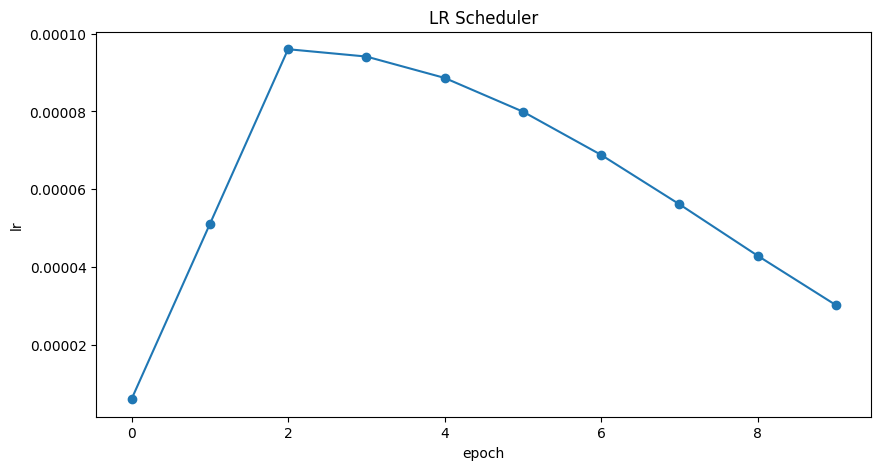

In [69]:
lr_cb = get_lr_callback(TGT_BATCH_SIZE, plot=True)

In [70]:
checkpoint_path = f'/kaggle/working/model_checkpoint_fold_1.weights.h5'
print(checkpoint_path)

# Define the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',  # Monitor validation loss
    save_weights_only=True,  # Save only the model weights
    save_best_only=True,  # Save only the best model
    verbose=1  # Verbosity mode. 0 or 1.
)

/kaggle/working/model_checkpoint_fold_1.weights.h5


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy
    patience=2,              # Number of epochs with no improvement after which training will be stopped
    mode='max',              # We want to maximize accuracy
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

In [71]:
history = model.fit(
        tf_train_dataset,
        epochs=1,
        validation_data=tf_val_dataset,
        callbacks=[lr_cb, checkpoint_callback,early_stopping]
    )

1452809491
(224, 224, 5)
(224, 224, 10)
(224, 224, 10)
2587679358
(224, 224, 5)
(224, 224, 10)
(224, 224, 10)
2262987632
(224, 224, 5)
(224, 224, 10)
(224, 224, 10)
857629562
(224, 224, 5)
(224, 224, 10)
(224, 224, 10)
1529405332
(224, 224, 5)
(224, 224, 10)
(224, 224, 10)
4122788296
(224, 224, 5)
(224, 224, 10)
(224, 224, 10)
2653438530
(224, 224, 5)
(224, 224, 10)
(224, 224, 10)
2530932856
(224, 224, 5)
(224, 224, 10)
(224, 224, 10)
947021330
(224, 224, 5)
(224, 224, 10)
(224, 224, 10)
305152236
(224, 224, 5)
(224, 224, 10)
(224, 224, 10)
1255232732
(224, 224, 5)
(224, 224, 10)
(224, 224, 10)
527598501
(224, 224, 5)
(224, 224, 10)
(224, 224, 10)
366818079
(224, 224, 5)
(224, 224, 10)
(224, 224, 10)
3867046855
(224, 224, 5)
(224, 224, 10)
(224, 224, 10)
1703545013
(224, 224, 5)
(224, 224, 10)
(224, 224, 10)
883950312
(224, 224, 5)
(224, 224, 10)
(224, 224, 10)
3837345060
(224, 224, 5)
(224, 224, 10)
(224, 224, 10)
3509104796
(224, 224, 5)
(224, 224, 10)
(224, 224, 10)
2851578449
(224,

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1009445512
(224, 224, 5)
(224, 224, 10)
(224, 224, 10)
117720278
(224, 224, 5)
(224, 224, 10)
(224, 224, 10)
1753007204
(224, 224, 5)
(224, 224, 10)
(224, 224, 10)
11340341
(224, 224, 5)
(224, 224, 10)
(224, 224, 10)
1217477368
(224, 224, 5)
(224, 224, 10)
(224, 224, 10)
664752325
(224, 224, 5)
(224, 224, 10)
(224, 224, 10)
1734639980
(224, 224, 5)
(224, 224, 10)
(224, 224, 10)
1459964234
(224, 224, 5)
(224, 224, 10)
(224, 224, 10)
1641631752
(224, 224, 5)
(224, 224, 10)
(224, 224, 10)
859100583
(224, 224, 5)
(224, 224, 10)
(224, 224, 10)
1864762516
(224, 224, 5)
(224, 224, 10)
(224, 224, 10)
1580580328
(224, 224, 5)
(224, 224, 10)
(224, 224, 10)
2718854859
(224, 224, 5)
(224, 224, 10)
(224, 224, 10)
3033395470
(224, 224, 5)
(224, 224, 10)
(224, 224, 10)
2232794498
(224, 224, 5)
(224, 224, 10)
(224, 224, 10)
1576224571
(224, 224, 5)
(224, 224, 10)
(224, 224, 10)
769420103
(224, 224, 5)
(224, 224, 10)
(224, 224, 10)
1004726367
(224, 224, 5)
(224, 224, 10)
(224, 224, 10)
691886557
(224, 

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


50/50 ━━━━━━━━━━━━━━━━━━━━ 2077s 30s/step - accuracy: 0.3699 - loss: 4.0950 - val_accuracy: 0.5772 - val_loss: 3.8289 - learning_rate: 6.0000e-06
